# Assignment 3  - Part B  - TensorFlow


#### Roll Number:

You have a choice in Part B. You can either choose to do using TensorFlow or using Pytorch. Both are equally good and are widely used in industry.

You are only required to do one of them. It's upto you to decide which one. However, you can also do both. In case you do both, you have to choose one as primary and and other one as secondary. Your primary one will be marked as normal and secondary one will marked for a 10% bonus.

For example, if you do both and choose tensorflow as your primary attempt then you should primary in first heading of tensorflow notebook (Assignment 3  - Part B  - TensorFlow - Primary) and secondary (Assignment 3  - Part B  - Pytorch - Secondary) in pytorch notebook.

In case, you only do one then you just need to submit that notebook.

### Task Explanation

In this part we will implement, train and evaluate a neural network using tensorflow on wheat disease classification problem. 

Wheat rust is a devastating plant disease that affects many crops, reducing yields and affecting the livelihoods of farmers and decreasing food security across the continent. The disease is difficult to monitor at a large scale, making it difficult to control and eradicate.

The objective of this challenge is to build a machine learning algorithm to correctly classify if a plant is healthy, has stem rust, or has leaf rust.

### Let's Start

Make necessary imports here e.g. import cv2, import glob, etc

In [56]:
import random
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
import pandas as pd
from skimage import io
import seaborn as sns
# any other imports that you may require

### Hyperparameters

You can play with these to improve accuracy on test data.

In [57]:
batch_size = 32
epochs = 30
learning_rate = 0.0001
input_shape = (256,256,3)

### Data

Get Wheat Disease Data for training and testing

In [58]:
!git clone https://github.com/MMFa666/WheatDiseaseDataset.git

fatal: destination path 'WheatDiseaseDataset' already exists and is not an empty directory.


Get paths for all the training images in the dataset and print the length of training_paths list. For this purpose you can use glob. You can have a look [here](https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/) on how to use glob.

In [59]:
# code here
training_paths = []
healthy_wheat = glob.glob('/home/daniyal/Desktop/CS437_HW3/PartB/WheatDiseaseDataset/train/healthy_wheat/*.jpg')
# print(len(healthy_wheat))
leaf_rust = glob.glob('/home/daniyal/Desktop/CS437_HW3/PartB/WheatDiseaseDataset/train/leaf_rust/*.jpg')
# print(len(leaf_rust))
stem_rust = glob.glob('/home/daniyal/Desktop/CS437_HW3/PartB/WheatDiseaseDataset/train/stem_rust/*.jpg')
# print(len(stem_rust))
training_paths = healthy_wheat + leaf_rust + stem_rust
print(len(training_paths))


699


Do the same for testing data images.

In [60]:
# code here
testing_paths = []
healthy_wheat = glob.glob('/home/daniyal/Desktop/CS437_HW3/PartB/WheatDiseaseDataset/test/healthy_wheat/*.jpg')
# print(len(healthy_wheat))
leaf_rust = glob.glob('/home/daniyal/Desktop/CS437_HW3/PartB/WheatDiseaseDataset/test/leaf_rust/*.jpg')
# print(len(leaf_rust))
stem_rust = glob.glob('/home/daniyal/Desktop/CS437_HW3/PartB/WheatDiseaseDataset/test/stem_rust/*.jpg')
# print(len(stem_rust))
testing_paths = healthy_wheat + leaf_rust + stem_rust
print(len(testing_paths))


177


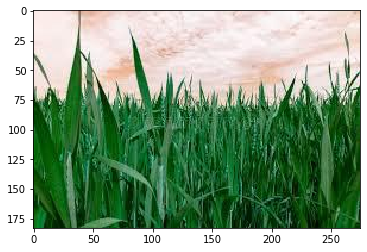

In [61]:
image = cv2.imread(testing_paths[0])
image = image/255
plt.imshow(image)


### Labels

In [62]:
labels={}
labels['healthy_wheat'] = 0
labels['leaf_rust'] = 1
labels['stem_rust'] = 2
print(labels)
print(len(labels))

{'healthy_wheat': 0, 'leaf_rust': 1, 'stem_rust': 2}
3


### Preprocessing

Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. In this task, we will only do normaliztion.

In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.


In [63]:
def preprocessing_norm(images):
          images = images/255.0
          return images

### Batch Generator

Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. 

For examples of batch_generators, you can have a look [here](https://www.geeksforgeeks.org/generators-in-python/) or [here](https://www.programcreek.com/python/?CodeExample=generate+batches). Essentially you have to the following:
- Shuffle the paths to get a uniform distribution in all batches.
- Divide paths into batches.
- Read image from the path. (Remeber cv2 reads image in BGR format.)
- Resize each image to input_shape.
- Extract label of the image from the image path using folder name. (Hint: You can do this by splitting the path.)
- One-hot encode the labels.
- Yield images and labels in tuple.



(300, 168, 3)
(3, 256, 256)
21


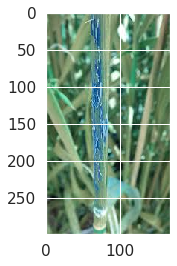

In [116]:
# read image from the path
images = []
image =  cv2.imread(training_paths[0])
# image = np.reshape(image,input_shape)
# print(image.shape)
io.imshow(image)
print(image.shape)

# for paths in training_paths:
image =  cv2.resize(image,(256,256))
image = np.transpose(image)
print(image.shape)
print(len(training_paths)//batch_size)

In [65]:
# Batch generator function here.

def batch_generator(paths,labels,batch_size):
    while True:
        random.shuffle(paths)
        for index in range(0,len(paths),batch_size):
            temp_paths = paths[index:index+batch_size]
            images_ = []
            labels_ = []
            for i in range(len(temp_paths)):
                path = temp_paths[i]
                image = cv2.imread(path)
                image = preprocessing_norm(image)
                image = cv2.resize(image,(256,256))
    #             image = np.transpose(image)
                images_.append(image)
                list_ = path.split("/")
                if 'healthy_wheat' in list_:
                    label =[1,0,0]
                elif 'leaf_rust' in list_:
                    label = [0,1,0]
                elif 'stem_rust' in list_:
                    label = [0,0,1]
                labels_.append(label)
            yield (np.array(images_), np.array(labels_))


Initialize train data generator

In [66]:
# code here
train_generator = batch_generator(training_paths,labels,batch_size)
x = next(train_generator)
print(x)


(array([[[[0.24509804, 0.32745098, 0.53137255],
         [0.23504902, 0.31740196, 0.52132353],
         [0.21764706, 0.29607843, 0.51960784],
         ...,
         [0.39142157, 0.6504902 , 0.62573529],
         [0.05343137, 0.24558824, 0.28480392],
         [0.06004902, 0.25220588, 0.29142157]],

        [[0.25588235, 0.33823529, 0.54215686],
         [0.23455882, 0.31691176, 0.52083333],
         [0.20392157, 0.28235294, 0.50588235],
         ...,
         [0.38161765, 0.59901961, 0.60735294],
         [0.08063725, 0.26495098, 0.31985294],
         [0.07279412, 0.25710784, 0.3120098 ]],

        [[0.23823529, 0.32058824, 0.53627451],
         [0.23823529, 0.32058824, 0.53627451],
         [0.21397059, 0.29632353, 0.5120098 ],
         ...,
         [0.18112745, 0.37818627, 0.39877451],
         [0.20588235, 0.37843137, 0.44509804],
         [0.12647059, 0.30294118, 0.35784314]],

        ...,

        [[0.        , 0.1375    , 0.15318627],
         [0.0252451 , 0.17034314, 0.18602941

### Training

Build model here. Use Functional API of tensorflow to this. You can have a look [here](https://www.tensorflow.org/guide/keras/functional) to understand how this works.

Model Architecture:
- See model.png for model architecture
- Filter size in each convolution layer is 3 except first convolution where it is 5.
- The stride in each convolution layer is 2.
- There is no padding in convolution layer.
- Dropout = 0.2 on each dropout layer.
- The last layer has softmax activation.
- The model should have 491,443 total parameters.


In [80]:
print(input_shape)

(256, 256, 3)


In [86]:
# Code here
inputs = Input(shape=input_shape)


conv2d_35 = Conv2D(filters=256,kernel_size=5,strides=2)
out = conv2d_35(inputs)
batch_normalization_35 = BatchNormalization()
out = batch_normalization_35(out)
leaky_re_lu_49 = LeakyReLU()
out = leaky_re_lu_49(out)
dropout_31 = Dropout(rate = 0.2)
out = dropout_31(out)

#         second layer
conv2d_36 = Conv2D(filters=128,kernel_size=3,strides=2)
out = conv2d_36(out)
batch_normalization_36 = BatchNormalization()
out = batch_normalization_36(out)
leaky_re_lu_50 = LeakyReLU()
out = leaky_re_lu_50(out)
dropout_32 = Dropout(rate = 0.2)
out = dropout_32(out)

#         third layer
conv2d_37 = Conv2D(filters=64,kernel_size=3,strides=2)
out = conv2d_37(out)
batch_normalization_37 = BatchNormalization()
out = batch_normalization_37(out)
leaky_re_lu_51 = LeakyReLU()
out = leaky_re_lu_51(out)
dropout_33 = Dropout(rate = 0.2)
out = dropout_33(out)

#         fourth layer
conv2d_38 = Conv2D(filters=32,kernel_size=3,strides=2)
out = conv2d_38(out)
batch_normalization_38 = BatchNormalization()
out = batch_normalization_38(out)
leaky_re_lu_52 = LeakyReLU()
out = leaky_re_lu_52(out)
dropout_34 = Dropout(rate = 0.2)
out = dropout_34(out)

#         fifth layer
conv2d_39 = Conv2D(filters=16,kernel_size=3,strides=2)
out = conv2d_39(out)
batch_normalization_39 = BatchNormalization()
out = batch_normalization_39(out)
leaky_re_lu_53 = LeakyReLU()
out = leaky_re_lu_53(out)
dropout_35 = Dropout(rate = 0.2)
out = dropout_35(out)

flatten_7 = Flatten()
out = flatten_7(out)

dense_21 = Dense(128)
out = dense_21(out)
leaky_re_lu_54 = LeakyReLU()
out = leaky_re_lu_54(out)
dropout_36 = Dropout(rate = 0.2)
out = dropout_36(out)

dense_22 = Dense(32)
out = dense_22(out)
leaky_re_lu_55 = LeakyReLU()
out = leaky_re_lu_55(out)
dropout_37 = Dropout(rate = 0.2)
out = dropout_37(out)

dense_23 = Dense(3, activation = "softmax")
out = dense_23(out)

model = Model(inputs=inputs, outputs = out, name = "weath_classification")


In [87]:
#print model summary here
model.summary()

Model: "weath_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 126, 126, 256)     19456     
_________________________________________________________________
batch_normalization_65 (Batc (None, 126, 126, 256)     1024      
_________________________________________________________________
leaky_re_lu_91 (LeakyReLU)   (None, 126, 126, 256)     0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 126, 126, 256)     0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 62, 62, 128)       295040    
_________________________________________________________________
batch_normalization_66 (Batc (None, 62, 62, 12

Compile your model here. (Hint: use model.compile() ) See [this](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) documentation or the above link to know how to do this. 

Use the following specifications:
- optimizer: Adam
- metrics: accuracy
- loss: categorical_crossentropy

In [88]:
# Code here
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='binary_crossentropy',   metrics=['accuracy'])


Fit your model here. (Hint: use model.fit() ) See [this](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation or the above link again to know how to do this.

In [104]:
# Code here
hist = model.fit(x = train_generator, epochs=30, verbose=2, steps_per_epoch=22)

Epoch 1/30
22/22 - 68s - loss: 0.2816 - accuracy: 0.8469
Epoch 2/30
22/22 - 70s - loss: 0.2708 - accuracy: 0.8655
Epoch 3/30
22/22 - 69s - loss: 0.2725 - accuracy: 0.8426
Epoch 4/30
22/22 - 69s - loss: 0.2639 - accuracy: 0.8498
Epoch 5/30
22/22 - 70s - loss: 0.2441 - accuracy: 0.8641
Epoch 6/30
22/22 - 69s - loss: 0.2406 - accuracy: 0.8698
Epoch 7/30
22/22 - 69s - loss: 0.2232 - accuracy: 0.8841
Epoch 8/30
22/22 - 70s - loss: 0.2069 - accuracy: 0.9013
Epoch 9/30
22/22 - 68s - loss: 0.1956 - accuracy: 0.8984
Epoch 10/30
22/22 - 69s - loss: 0.1964 - accuracy: 0.9070
Epoch 11/30
22/22 - 71s - loss: 0.1853 - accuracy: 0.9142
Epoch 12/30
22/22 - 68s - loss: 0.1797 - accuracy: 0.9084
Epoch 13/30
22/22 - 70s - loss: 0.1702 - accuracy: 0.9170
Epoch 14/30
22/22 - 69s - loss: 0.1781 - accuracy: 0.9127
Epoch 15/30
22/22 - 69s - loss: 0.1869 - accuracy: 0.9041
Epoch 16/30
22/22 - 69s - loss: 0.1596 - accuracy: 0.9084
Epoch 17/30
22/22 - 70s - loss: 0.1597 - accuracy: 0.9270
Epoch 18/30
22/22 - 70s

Plot the loss and accuracy graphs of training. Use hist.history['loss'] and hist.history['accuracy'] where hist is returned by model.fit()

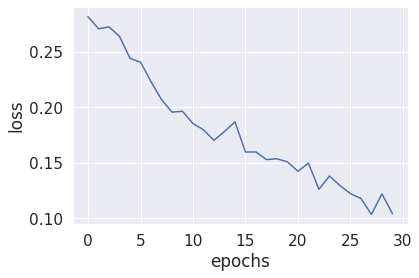

In [105]:
# Loss Plot
loss = hist.history['loss']
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(loss)

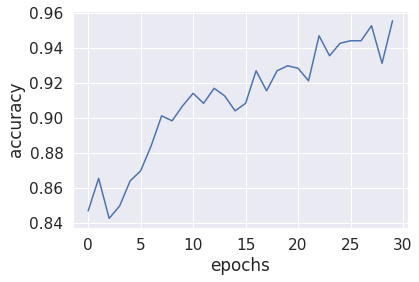

In [106]:
# Accuracy Plot
accuracy = hist.history['accuracy']
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(accuracy)


### Evaluation

Now, we will evaluate our model on the test data.

First, let's read the test data using test_paths. Similar to what we did in batch_generator.

In [107]:
# code here
random.shuffle(testing_paths)
images_ = []
labels_ = []

for i in range(len(testing_paths)):
    path = testing_paths[i]
    image = cv2.imread(path)
    image = preprocessing_norm(image)
    image = cv2.resize(image,(256,256))
#             image = np.transpose(image)
    images_.append(image)
    list_ = path.split("/")
    if 'healthy_wheat' in list_:
        label =[1,0,0]
    elif 'leaf_rust' in list_:
        label = [0,1,0]
    elif 'stem_rust' in list_:
        label = [0,0,1]
    labels_.append(label)
images = np.array(images_)
test_labels=  np.array(labels_)


Now, make predictions on test data. (Hint: use model.predict() ).

In [108]:
# code here
predictions = model.predict(x = images, batch_size = 1, verbose = 1)


177/177 [==============================] - 2s 10ms/step


Extract class label from predictions. (Hint: you can use np.argmax() ).

In [109]:
# code here
# print(predictions)
predictions = np.argmax(predictions,axis = 1)


Calculate and print accuracy.

In [110]:
# code here
test_labels = np.argmax(test_labels, axis = 1)
x = 0
for i in range(len(predictions)):
      if(predictions[i] == test_labels[i]):
            x = x+1
accuracy = (x/len(predictions))*100
print("Percentge of accurate predictions: ", accuracy)

Percentge of accurate predictions:  68.92655367231639


Calculate and print Confusion Matrix. Have a look [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for this.

In [111]:
# code here
pred_ = []
for pred in (predictions):
        if(pred == 0): 
                pred_.append("healthy_wheat")
        elif(pred == 1): 
                pred_.append("stem_rust")
        elif(pred == 2): 
                pred_.append("leaf_rust")

test_ = []
for label in (test_labels):
            if(label == 0): 
                test_.append("healthy_wheat")
            elif(label == 1): 
                test_.append("stem_rust")
            elif(label == 2): 
                test_.append("leaf_rust")
            
            
conf_mat = confusion_matrix(test_,pred_)


In [112]:
def plot_confusion_matrix(conf_mat):
    classes = list(labels.keys())
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

Use the above function to plot confusion matrix here.

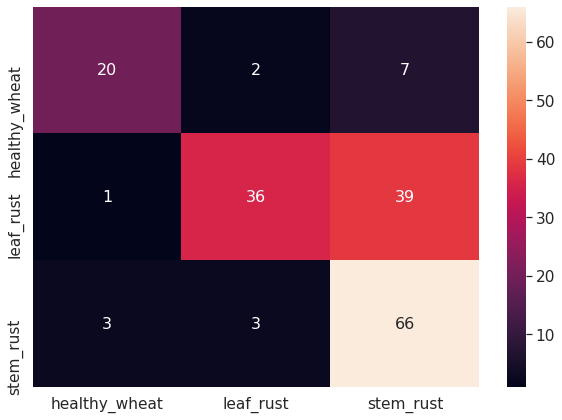

In [113]:
# code below
plot_confusion_matrix(conf_mat)

### Questions



What is overfitting? How are we trying to prevent overfitting here?

Answer:In statistics, overfitting is "the production of an analysis that corresponds too closely or exactly to a particular set of data, and may therefore fail to fit additional data or predict future observations reliably". Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model. The problem is that these concepts do not apply to new data and negatively impact the models ability to generalize.
Here we are trying to prevent overfitting by using dropout activation layers. 


What is class imbalance? How does it effect training? Does this training set have class imbalance? If yes, then show it (using numbers).

Answer:Data are said to suffer the Class Imbalance Problem when the class distributions are highly imbalanced. When we have a class imbalance, the machine learning classifier tends to be more biased towards the majority class, causing bad classification of the minority class.There is a class imbalance in our datset because the difference between 'healty_wheat' and the other two classes is more than twice the number of images of other two classes.